Desafio Ciências de Dados

Alexandre Miguel de Carvalho

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
from fbprophet import Prophet
from sklearn.metrics import mean_squared_log_error
plt.style.use('fivethirtyeight')

In [19]:
df = pd.read_excel('./input/dataset_desafio_datascience.xlsx')

In [20]:
def str_2_datetime(df, field):
	order_date = df[field]
	df[field] = order_date.map(lambda x: datetime.strptime(x, '%d-%m-%Y'))
	
	return df

In [21]:
def verify_dataset(df):
	col = df.columns
	#print(df.shape)  # dataset shape
	for c in col:
		nan_counter = df[c].isnull().sum()
		print(c, nan_counter)  # Postal Code 41296 NaN (delete it)

In [22]:
def delete_irrelevant_feature(df, field):
	'''
	Delete irrelevant features like Postal_Code (in the specific problem)
	:param df: dataframe with all data
	:param field: column to be removed
	:return: filtered dataframe
	'''
	
	df = df.drop(columns=[field])
	return df

In [23]:
def volume_vendas(df):
	dfr = pd.DataFrame(columns=['Segment', 'Total_Order'])
	ind = 0
	df_temp = df.groupby(by=['Segment'])
	for name, group in df_temp:
		group = group.reset_index()
		try:
			group = delete_irrelevant_feature(group, 'index')
		except:
			print("index col not found")
		
		segment = group.loc[0, 'Segment']
		dfr.at[ind, 'Segment'] = segment
		dfr.at[ind, 'Total_Order'] = group['Quantity'].sum()
		ind = ind + 1
	
	dfr.to_csv('./output/segmento_volume.csv', index=False)
	return dfr

In [24]:
def tempo_medio_entrega(df):
	dfr = pd.DataFrame(columns=['Country'])
	ind = 0
	df_temp = df.groupby(by=['Country'])
	for name, group in df_temp:
		group = group.reset_index()
		try:
			group = delete_irrelevant_feature(group, 'index')
		except:
			print("index col not found")
		
		l = group.shape[0]
		country = group.loc[0, 'Country']
		dfr.at[ind, 'Country'] = country
		dfr.at[ind, 'Market'] = group.loc[0, 'Market']
		dfr.at[ind, 'Region'] = group.loc[0, 'Region']
		dfr.at[ind, 'Category'] = group.loc[0, 'Category']
		dfr.at[ind, 'Sub-Category'] = group.loc[0, 'Sub-Category']
		
		for i in np.arange(0, l):
			group.loc[i, 'Days'] = (group.loc[i, 'Ship Date'] - group.loc[i, 'Order Date']).days
		
		dfr.at[ind, 'Median_Delivery_days'] = group['Days'].median()
		dfr.at[ind, 'Average_Delivery_days'] = group['Days'].mean()
		dfr.at[ind, 'STD'] = group['Days'].std()
		dfr.at[ind, 'VARIANCE'] = group['Days'].var()
		ind = ind + 1
	
	dfr.to_csv('./output/tempo_medio_entrega.csv', index=False)
	return dfr

In [25]:
def clientes_rentaveis_ano(df):
	begin_year = df['Order Date'].dt.year.min()
	end_year = df['Order Date'].dt.year.max()
	years = []
	while begin_year <= end_year:
		years.append(begin_year)
		begin_year = begin_year + 1
	
	for y in years:
		dfyear = df[df['Order Date'].dt.year == y]
		dfr = pd.DataFrame(columns=['Segment'])
		ind = 0
		df_temp = dfyear.groupby(by=['Segment', 'Country', 'Category', 'Sub-Category'])
		for name, group in df_temp:
			group = group.reset_index()
			try:
				group = delete_irrelevant_feature(group, 'index')
			except:
				print("index col not found")
			
			dfr.at[ind, 'Year'] = y
			dfr.at[ind, 'Country'] = group.loc[0, 'Country']
			dfr.at[ind, 'Market'] = group.loc[0, 'Market']
			dfr.at[ind, 'Region'] = group.loc[0, 'Region']
			dfr.at[ind, 'Category'] = group.loc[0, 'Category']
			dfr.at[ind, 'Sub-Category'] = group.loc[0, 'Sub-Category']
			
			dfr.at[ind, 'Segment'] = group.loc[0, 'Segment']
			dfr.at[ind, 'Profit'] = group['Profit'].sum()
			ind = ind + 1
		
		dfr.to_csv('./output/segmento_rentavel_' + str(y) + '.csv', index=False)
		
		dfr1 = pd.DataFrame(columns=['Segment'])
		ind1 = 0
		df_temp = dfr.groupby(by=['Segment'])
		for name, group in df_temp:
			group = group.reset_index()
			try:
				group = delete_irrelevant_feature(group, 'index')
			except:
				print("index col not found")
			
			dfr1.at[ind1, 'Year'] = y
			dfr1.at[ind1, 'Segment'] = group.loc[0, 'Segment']
			dfr1.at[ind1, 'Profit'] = group['Profit'].sum()
			ind1 = ind1 + 1
		
		dfr1.to_csv('./output/segmento_rentavel_total_' + str(y) + '.csv', index=False)

In [26]:
def distribuicao_clientes(df):
	dfr = pd.DataFrame(columns=['Country', 'Segment', 'Clients'])
	ind = 0
	df_temp = df.groupby(by=['Country', 'Segment'])
	for name, group in df_temp:
		group = group.reset_index()
		try:
			group = delete_irrelevant_feature(group, 'index')
		except:
			print("index col not found")
		
		dfr.at[ind, 'Country'] = group.loc[0, 'Country']
		dfr.at[ind, 'Segment'] = group.loc[0, 'Segment']
		dfr.at[ind, 'Clients'] = group['customer ID'].unique().shape[0]
		ind = ind + 1
	
	dfr.to_csv('./output/distribuicao_clientes.csv', index=False)
	df_temp = dfr.groupby(by=['Country'])
	for name, group in df_temp:
		label = list(group['Segment'])
		values = list(group['Clients'])
		pizza_graph(name, values, label)
        
	return dfr


In [27]:
def pizza_graph(country, values, labels):
	plt.pie(values, labels=labels, autopct='%1.1f%%')
	plt.title(country)
	plt.axis('equal')
	plt.savefig('./output/distribuicao_clientes_' + country + '.pdf', dpi=300,
	            bbox_inches='tight')
	plt.close()

In [28]:
def frequencia_compra(df):
	dfr = pd.DataFrame(columns=['customer ID'])
	ind = 0
	df_temp = df.groupby(by=['customer ID'])
	for name, group in df_temp:
		group = group.reset_index()
		try:
			group = delete_irrelevant_feature(group, 'index')
		except:
			print("index col not found")
		
		# mesmo customer ID em varios paises
		dfr.at[ind, 'customer ID'] = group.loc[0, 'customer ID']
		dfr.at[ind, 'Frequency'] = group['Order Date'].unique().shape[0]  # data ultima compra
		dfr.at[ind, 'Profit'] = group['Profit'].sum()
		dfr.at[ind, 'Sales'] = group['Sales'].sum()  # considerando que a sales = quantidade x preco unitario
		last_purchase = group['Order Date'].max()
		reference_date = datetime.strptime('31-12-2014', '%d-%m-%Y')
		recencia = (reference_date - last_purchase).days
		dfr.at[ind, 'Recencia'] = recencia
		
		if recencia == 0:
			recencia = 1
		
		dfr.at[ind, 'CustomerValue'] = (dfr.at[ind, 'Frequency'] * dfr.at[ind, 'Profit']) / recencia  # quanto maior o
		# tempo de ultima compra menor o valor do cliente
		ind = ind + 1
	# Profit,Sales,Recencia,CustomerValue
	dfr['Profit'] = np.round(dfr['Profit'], decimals=2)
	dfr['Sales'] = np.round(dfr['Sales'], decimals=2)
	dfr['Recencia'] = np.round(dfr['Recencia'], decimals=2)
	dfr['CustomerValue'] = np.round(dfr['CustomerValue'], decimals=2)
	
	dfr = dfr.sort_values(by=['CustomerValue'], ascending=False)
	dfr.to_csv('./output/valor_do_cliente.csv', index=False)
	df1 = dfr[dfr['Profit'] > 0]  # lucro positivo
	df2 = dfr[dfr['Profit'] <= 0]  # prejuizo
	df3 = dfr[dfr['Sales'] > 0]  # faturamento bruto
	
	x = df1['Frequency']
	y = df1['Profit']
	fig, ax = plt.subplots(figsize=(10, 5))
	ax.scatter(x, y)
	ax.set_title('Frequency x Profit')
	ax.set_xlabel('Purchase Frequency in 4 Years')
	ax.set_ylabel('Profit by Client')
	plt.savefig('./output/frequencia_compras_lucro.pdf', dpi=300, bbox_inches='tight')
	plt.close()
	
	x = df2['Frequency']
	y = df2['Profit']
	fig, ax = plt.subplots(figsize=(10, 5))
	ax.scatter(x, y)
	ax.set_title('Frequency x Profit')
	ax.set_xlabel('Purchase Frequency in 4 Years')
	ax.set_ylabel('Profit by Client')
	plt.savefig('./output/frequencia_compras_prejuizo.pdf', dpi=300, bbox_inches='tight')
	plt.close()
	
	x = df3['Frequency']
	y = df3['Sales']
	fig, ax = plt.subplots(figsize=(10, 5))
	ax.scatter(x, y)
	ax.set_title('Frequency x Sales')
	ax.set_xlabel('Purchase Frequency in 4 Years')
	ax.set_ylabel('Sales by Client')
	plt.savefig('./output/frequencia_compras_faturamento_bruto.pdf', dpi=300, bbox_inches='tight')
	plt.close()

In [29]:
df

,Order ID,Order Date,Ship Date,Ship Mode,customer ID,Customer Name,Segment,City,State,Country,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,ES-2011-5338028,28-12-2011,01-01-2012,Second Class,18115,Mick Hernandez,Home Office,Turin,Piedmont,Italy,...,FUR-BO-10003541,Furniture,Bookcases,"Bush Classic Bookcase, Metal",1236.420,3,0.0,420.3000,139.93,Medium
1,ID-2011-24160,29-12-2011,01-01-2012,Second Class,20170,Sarah Bern,Consumer,Gold Coast,Queensland,Australia,...,TEC-PH-10002601,Technology,Phones,"Motorola Smart Phone, Cordless",578.502,1,0.1,-38.5680,131.81,Critical
2,CA-2011-141313,28-12-2011,01-01-2012,Standard Class,10780,Anthony Jacobs,Corporate,Beverly,Massachusetts,United States,...,OFF-AP-10002651,Office Supplies,Appliances,Hoover Upright Vacuum With Dirt Cup,1737.180,6,0.0,503.7822,131.71,Medium
3,ID-2011-24160,29-12-2011,01-01-2012,Second Class,20170,Sarah Bern,Consumer,Gold Coast,Queensland,Australia,...,FUR-BO-10002308,Furniture,Bookcases,"Safco Floating Shelf Set, Metal",353.160,2,0.1,39.2400,92.20,Critical
4,CA-2011-104738,30-12-2011,01-01-2012,Second Class,20620,Stefania Perrino,Corporate,Laredo,Texas,United States,...,TEC-PH-10002468,Technology,Phones,"Plantronics CS 50-USB - headset - Convertible,...",217.584,2,0.2,19.0386,76.76,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,ES-2014-4706940,26-12-2014,31-12-2014,Standard Class,13120,David Bremer,Corporate,Marseille,Provence-Alpes-Côte d'Azur,France,...,OFF-AR-10001626,Office Supplies,Art,"BIC Pens, Blue",28.560,2,0.0,3.1200,0.63,Medium
51286,AG-2014-4720,27-12-2014,31-12-2014,Standard Class,9780,Rose O'Brian,Consumer,Oran,Oran,Algeria,...,OFF-STA-10003027,Office Supplies,Art,"Stanley Highlighters, Easy-Erase",14.970,1,0.0,5.3700,0.52,Medium
51287,MX-2014-156741,24-12-2014,31-12-2014,Standard Class,20725,Steven Cartwright,Consumer,Santiago,Santiago,Chile,...,OFF-BI-10004275,Office Supplies,Binders,"Wilson Jones Index Tab, Recycled",9.080,2,0.0,4.3200,0.51,Low
51288,TU-2014-3120,24-12-2014,31-12-2014,Standard Class,7785,Maya Herman,Corporate,Karaman,Karaman,Turkey,...,OFF-AVE-10001847,Office Supplies,Binders,"Avery Binder, Clear",4.944,1,0.6,-6.1860,0.31,Medium


In [30]:
verify_dataset(df)

Order ID 0
Order Date 0
Ship Date 0
Ship Mode 0
customer ID 0
Customer Name 0
Segment 0
City 0
State 0
Country 0
Postal Code 41296
Market 0
Region 0
Product ID 0
Category 0
Sub-Category 0
Product Name 0
Sales 0
Quantity 0
Discount 0
Profit 0
Shipping Cost 0
Order Priority 0


Deletamos o campo Postal Code porque não é necessário uma vez que tempos o nome da cidade, o estado e o país.Também porque [Postal Code 41296] há uma quantidade significativa de NaN.

In [31]:
df = delete_irrelevant_feature(df, 'Postal Code')

Não há a necessidade de sabermos o Product Name

In [32]:
df = delete_irrelevant_feature(df, 'Product Name')

Devemos converter as datas para um formato onde o Python possa realizar operações aritméticas com datas.

In [33]:
df = str_2_datetime(df, 'Order Date')

In [34]:
df = str_2_datetime(df, 'Ship Date')

Verificamos os campos e os tipos de dados do Dataframe

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order ID        51290 non-null  object        
 1   Order Date      51290 non-null  datetime64[ns]
 2   Ship Date       51290 non-null  datetime64[ns]
 3   Ship Mode       51290 non-null  object        
 4   customer ID     51290 non-null  int64         
 5   Customer Name   51290 non-null  object        
 6   Segment         51290 non-null  object        
 7   City            51290 non-null  object        
 8   State           51290 non-null  object        
 9   Country         51290 non-null  object        
 10  Market          51290 non-null  object        
 11  Region          51290 non-null  object        
 12  Product ID      51290 non-null  object        
 13  Category        51290 non-null  object        
 14  Sub-Category    51290 non-null  object        
 15  Sa

In [36]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'customer ID',
       'Customer Name', 'Segment', 'City', 'State', 'Country', 'Market',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [37]:
vendas = df['Sales']
dias = df['Order Date']
dfr = pd.DataFrame(columns=['ds','y'])
dfr['ds'] = dias
dfr['y'] = vendas

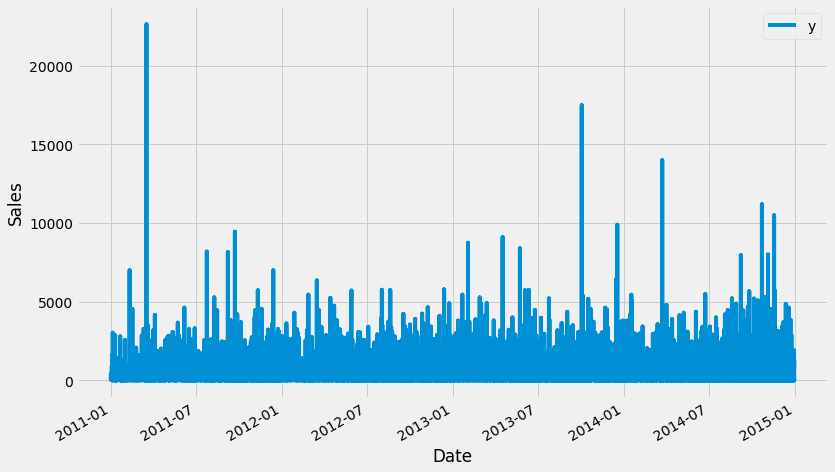

In [38]:
ax = dfr.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
plt.show()

Observando o gráfico acima podemos suspeitar de Outliers nos três primeiros picos porque não faz sentido o volume de vendas de 2011 ser muito maior que em 2014. Vamos verificar ano a ano o faturamento da coluna Sales

Ano de 2011

Inicio: 2011-01-01 00:00:00
Fim: 2011-12-31 00:00:00


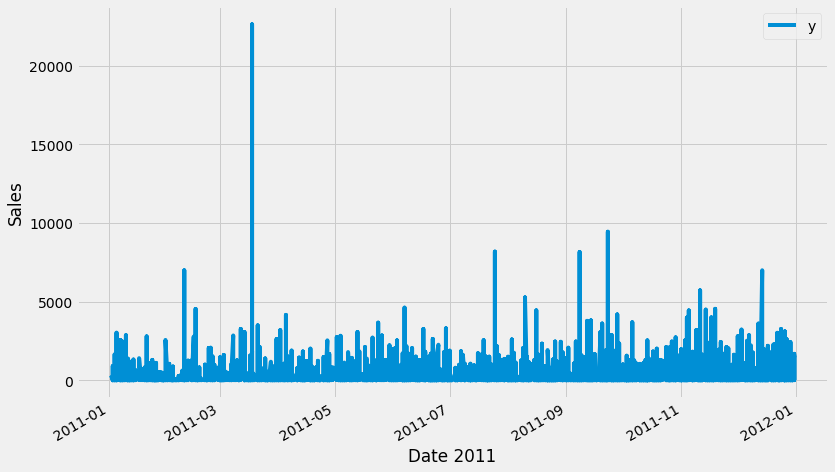

In [39]:
start_date =  datetime.strptime('01-01-2011', '%d-%m-%Y')
end_date =  datetime.strptime('31-12-2011', '%d-%m-%Y')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2011 = dfr.loc[mask]
ax = df_2011.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2011')
plt.show()

Restringindo à área de interesse temos:

Inicio: 2011-03-15 00:00:00
Fim: 2011-03-22 00:00:00


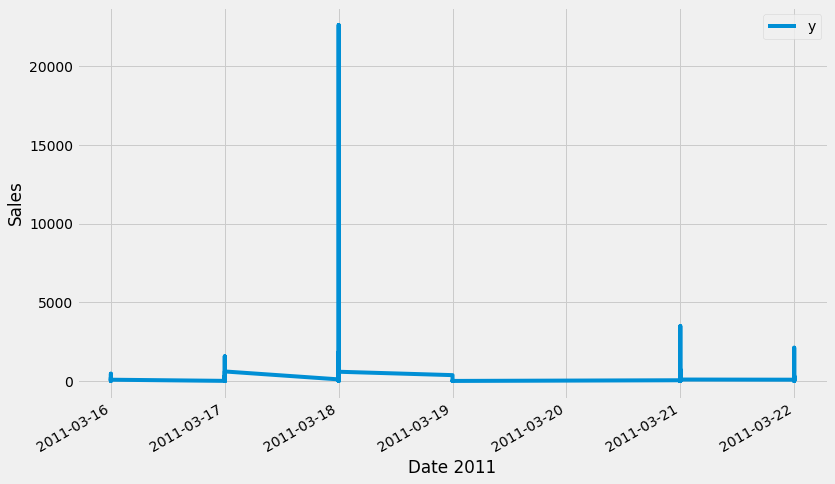

In [40]:
start_date =  datetime.strptime('15-03-2011', '%d-%m-%Y')
end_date =  datetime.strptime('22-03-2011', '%d-%m-%Y')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2011 = dfr.loc[mask]
ax = df_2011.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2011')
plt.show()

Temos um Outlier no dia 2011-03-18

Ano 2012
Inicio: 2012-01-01 00:00:00
Fim: 2012-12-31 00:00:00


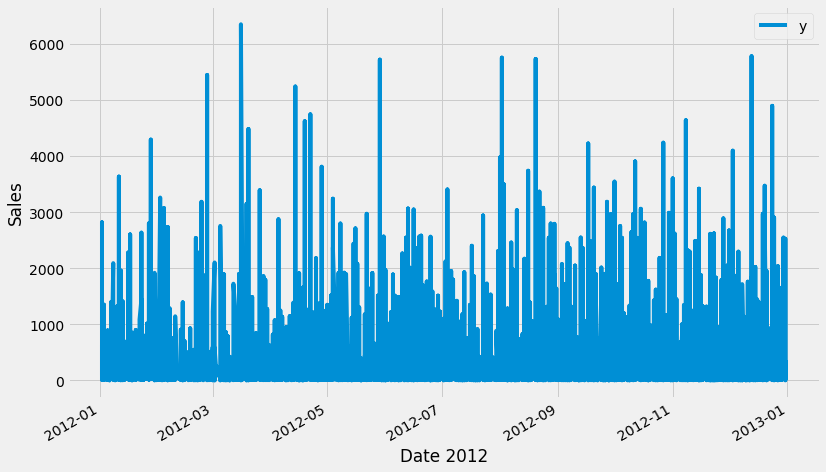

In [41]:
start_date =  datetime.strptime('01-01-2012', '%d-%m-%Y')
end_date =  datetime.strptime('31-12-2012', '%d-%m-%Y')
print('Ano 2012')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2012 = dfr.loc[mask]
ax = df_2012.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2012')
plt.show()

Ano 2013
Inicio: 2013-01-01 00:00:00
Fim: 2013-12-31 00:00:00


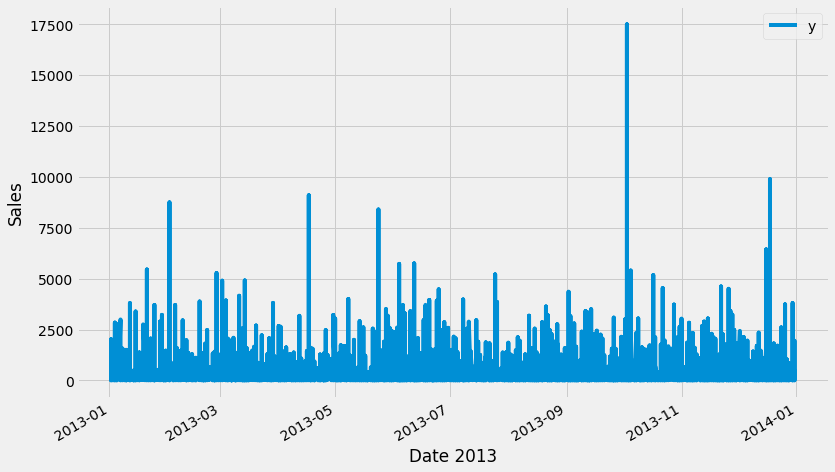

In [42]:
start_date =  datetime.strptime('01-01-2013', '%d-%m-%Y')
end_date =  datetime.strptime('31-12-2013', '%d-%m-%Y')
print('Ano 2013')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2013 = dfr.loc[mask]
ax = df_2013.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2013')
plt.show()

Restringindo para a área de interesse temos:

Ano 2013
Inicio: 2013-10-01 00:00:00
Fim: 2013-10-08 00:00:00


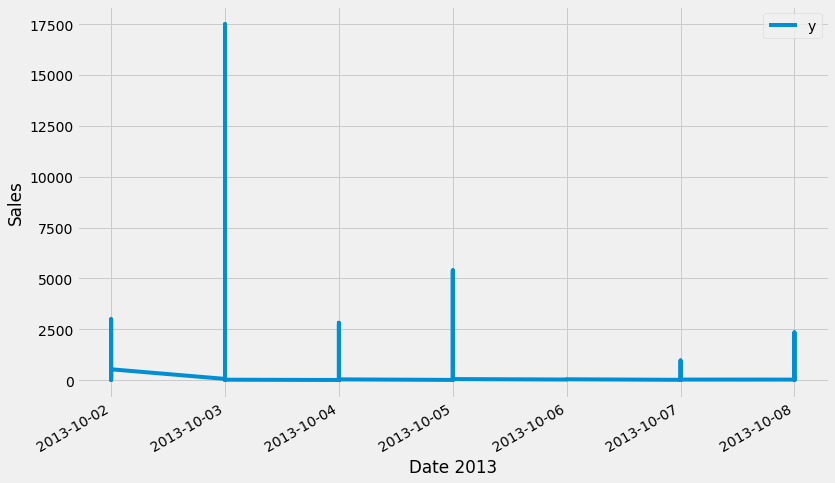

In [43]:
start_date =  datetime.strptime('01-10-2013', '%d-%m-%Y')
end_date =  datetime.strptime('08-10-2013', '%d-%m-%Y')
print('Ano 2013')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2013 = dfr.loc[mask]
ax = df_2013.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2013')
plt.show()

Temos um Outlier no dia 2013-10-03

Ano 2014
Inicio: 2014-01-01 00:00:00
Fim: 2014-12-31 00:00:00


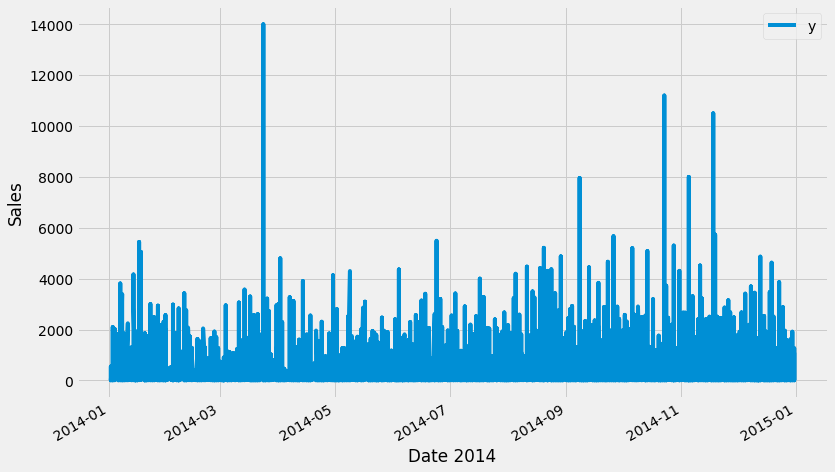

In [44]:
start_date =  datetime.strptime('01-01-2014', '%d-%m-%Y')
end_date =  datetime.strptime('31-12-2014', '%d-%m-%Y')
print('Ano 2014')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2014 = dfr.loc[mask]
ax = df_2014.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2014')
plt.show()

Ano 2014
Inicio: 2014-03-15 00:00:00
Fim: 2014-04-01 00:00:00


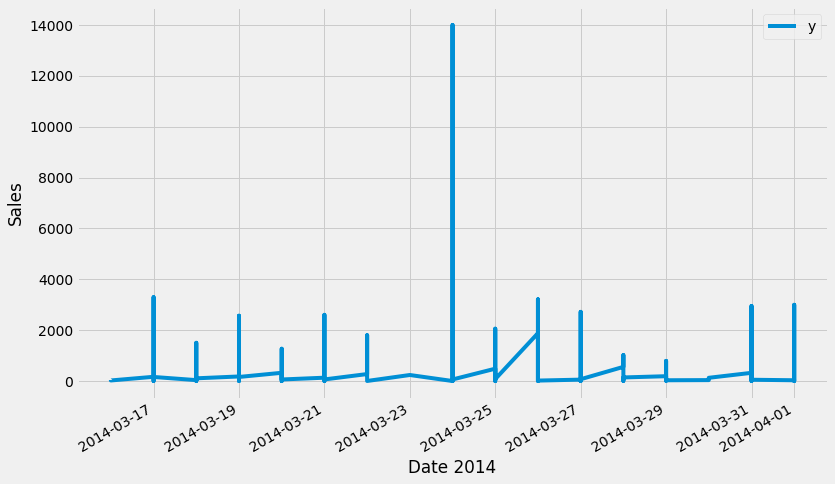

In [45]:
start_date =  datetime.strptime('15-03-2014', '%d-%m-%Y')
end_date =  datetime.strptime('01-04-2014', '%d-%m-%Y')
print('Ano 2014')
print('Inicio:',start_date)
print('Fim:',end_date)

mask = (dfr['ds'] > start_date) & (dfr['ds'] <= end_date)
df_2014 = dfr.loc[mask]
ax = df_2014.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date 2014')
plt.show()

Outlier 2014-03-25

Portanto, temos as seguinte suspeitas: 2011-03-18, 2013-10-03, 2014-03-24

In [46]:
suspeitos = df[df['Order Date'] == '2011-03-18']
suspeitos = suspeitos[['Order Date','customer ID','Segment','Sales','Profit']]
print(suspeitos['Sales'].sum())
print(suspeitos['Sales'].max())
suspeitos


30117.546200000004
22638.48


,Order Date,customer ID,Segment,Sales,Profit
31844,2011-03-18,20560,Home Office,56.5200,4.5000
33544,2011-03-18,13795,Home Office,1198.3300,70.4900
33552,2011-03-18,15265,Corporate,175.8240,7.7040
35246,2011-03-18,18865,Consumer,543.4560,70.1460
35248,2011-03-18,13780,Consumer,177.8760,27.6360
35251,2011-03-18,10240,Consumer,138.3942,35.0142
36956,2011-03-18,20320,Home Office,821.3000,-16.4260
36957,2011-03-18,12985,Consumer,595.6800,0.0000
36958,2011-03-18,20320,Home Office,22638.4800,-1811.0784
36961,2011-03-18,20320,Home Office,122.3520,15.2940


In [47]:
customer20320 = df[df['customer ID'] == 20320]
print('Máximo: ',customer20320['Sales'].max())
print('Mínimo: ',customer20320['Sales'].min())
print('Média: ',customer20320['Sales'].mean())

Máximo:  22638.48
Mínimo:  3.488
Média:  798.0844861538461


In [48]:
df.loc[36958,'Sales'] = customer20320['Sales'].mean()
df.loc[36958]

Order ID               CA-2011-145317
Order Date        2011-03-18 00:00:00
Ship Date         2011-03-23 00:00:00
Ship Mode              Standard Class
customer ID                     20320
Customer Name             Sean Miller
Segment                   Home Office
City                     Jacksonville
State                         Florida
Country                 United States
Market                             US
Region                          South
Product ID            TEC-MA-10002412
Category                   Technology
Sub-Category                 Machines
Sales                         798.084
Quantity                            6
Discount                          0.5
Profit                       -1811.08
Shipping Cost                   24.29
Order Priority                 Medium
Name: 36958, dtype: object

In [49]:
suspeitos = df[df['Order Date'] == '2013-10-03']
suspeitos = suspeitos[['Order Date','customer ID','Segment','Sales','Profit']]
print(suspeitos['Sales'].sum())
print(suspeitos['Sales'].max())
suspeitos

26325.297979999996
17499.95


,Order Date,customer ID,Segment,Sales,Profit
4535,2013-10-03,12205,Consumer,1287.43200,-536.44800
4539,2013-10-03,12205,Consumer,205.63200,-85.72800
4548,2013-10-03,12205,Consumer,7.09200,-2.74800
6206,2013-10-03,16435,Consumer,611.20000,183.36000
6224,2013-10-03,16435,Consumer,40.40000,12.08000
6227,2013-10-03,17095,Consumer,54.79200,-40.18080
6230,2013-10-03,13555,Corporate,38.56590,4.72590
6234,2013-10-03,16435,Consumer,31.88000,14.66000
6238,2013-10-03,16435,Consumer,24.12000,10.56000
7826,2013-10-03,13390,Home Office,13.53000,-4.89000


In [50]:
customer20980 = df[df['customer ID'] == 20980]
print('Máximo: ',customer20980['Sales'].max())
print('Mínimo: ',customer20980['Sales'].min())
print('Média: ',customer20980['Sales'].mean())

Máximo:  17499.95
Mínimo:  7.312
Média:  579.970661016949


In [51]:
df.loc[16054,'Sales'] = customer20980['Sales'].mean()
df.loc[16054]

Order ID               CA-2013-118689
Order Date        2013-10-03 00:00:00
Ship Date         2013-10-10 00:00:00
Ship Mode              Standard Class
customer ID                     20980
Customer Name            Tamara Chand
Segment                     Corporate
City                        Lafayette
State                         Indiana
Country                 United States
Market                             US
Region                        Central
Product ID            TEC-CO-10004722
Category                   Technology
Sub-Category                  Copiers
Sales                         579.971
Quantity                            5
Discount                            0
Profit                        8399.98
Shipping Cost                  349.07
Order Priority                 Medium
Name: 16054, dtype: object

In [52]:
suspeitos = df[df['Order Date'] == '2014-03-24']
suspeitos = suspeitos[['Order Date','customer ID','Segment','Sales','Profit']]
print(suspeitos['Sales'].sum())
print(suspeitos['Sales'].max())
suspeitos

23864.244499999997
13999.96


,Order Date,customer ID,Segment,Sales,Profit
38733,2014-03-24,11755,Consumer,91.7460,1.9860
38756,2014-03-24,11755,Consumer,15.3630,4.0830
42114,2014-03-24,17515,Corporate,347.5800,17.3790
42119,2014-03-24,10845,Consumer,474.0000,9.3600
42123,2014-03-24,19360,Consumer,13999.9600,6719.9808
42125,2014-03-24,11335,Home Office,211.8400,76.2624
42128,2014-03-24,3495,Corporate,78.2880,-58.7520
42140,2014-03-24,3495,Corporate,20.3160,-23.8740
42150,2014-03-24,3495,Corporate,6.8040,-3.0660
42151,2014-03-24,10905,Consumer,53.8020,-118.3980


In [53]:
customer19360 = df[df['customer ID'] == 19360]
print('Máximo: ',customer19360['Sales'].max())
print('Mínimo: ',customer19360['Sales'].min())
print('Média: ',customer19360['Sales'].mean())

Máximo:  13999.96
Mínimo:  4.448
Média:  449.19437846153835


Vamos agora susbstituir os Outliers pelos valores médios de compra do respectivo cliente.

In [54]:
df.loc[42123,'Sales'] = customer19360['Sales'].mean()
df.loc[42123]

Order ID               CA-2014-140151
Order Date        2014-03-24 00:00:00
Ship Date         2014-03-26 00:00:00
Ship Mode                 First Class
customer ID                     19360
Customer Name            Raymond Buch
Segment                      Consumer
City                          Seattle
State                      Washington
Country                 United States
Market                             US
Region                           West
Product ID            TEC-CO-10004722
Category                   Technology
Sub-Category                  Copiers
Sales                         449.194
Quantity                            4
Discount                            0
Profit                        6719.98
Shipping Cost                      20
Order Priority                 Medium
Name: 42123, dtype: object

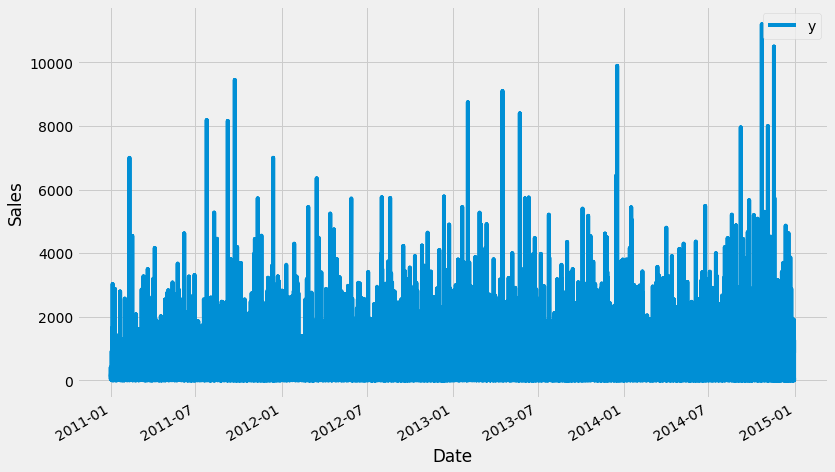

In [55]:
vendas = df['Sales']
dias = df['Order Date']
dfr = pd.DataFrame(columns=['ds','y'])
dfr['ds'] = dias
dfr['y'] = vendas
ax = dfr.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
plt.show()

Ainda há alguma suspeita de Outlier. Vamos ver ao final se é necessário filtrar mais.

Cálculo do tempo médio de entrega de todo o dataset.
Resultado no arquivo: './output/tempo_medio_entrega.csv'

In [58]:
tempo_medio_entrega(df)

,Country,Market,Region,Category,Sub-Category,Median_Delivery_days,Average_Delivery_days,STD,VARIANCE
0,Afghanistan,APAC,Central Asia,Furniture,Chairs,5.0,4.490909,1.184354,1.402694
1,Albania,EMEA,EMEA,Furniture,Bookcases,4.0,3.625000,1.821172,3.316667
2,Algeria,Africa,Africa,Furniture,Bookcases,4.0,3.852041,1.701747,2.895945
3,Angola,Africa,Africa,Office Supplies,Art,4.0,4.204918,1.366292,1.866752
4,Argentina,LATAM,South,Office Supplies,Supplies,4.0,3.825641,1.974219,3.897541
...,...,...,...,...,...,...,...,...,...
142,Venezuela,LATAM,South,Furniture,Chairs,4.0,4.273196,1.635932,2.676273
143,Vietnam,APAC,Southeast Asia,Office Supplies,Binders,4.0,3.811321,1.654386,2.736993
144,Yemen,EMEA,EMEA,Office Supplies,Storage,4.0,4.000000,1.414214,2.000000
145,Zambia,Africa,Africa,Office Supplies,Appliances,4.0,3.911765,1.683366,2.833722


Cálculo da rentabilidade dos clientes.

In [85]:
clientes_rentaveis_ano(df)

In [97]:
r2011 = pd.read_csv('./output/segmento_rentavel_total_2011.csv')
r2012 = pd.read_csv('./output/segmento_rentavel_total_2012.csv')
r2013 = pd.read_csv('./output/segmento_rentavel_total_2013.csv')
r2014 = pd.read_csv('./output/segmento_rentavel_total_2014.csv')
resultado_rentabilidade = pd.concat([r2011,r2012,r2013,r2014])

df_rentabilidade = pd.DataFrame(columns=['Segment', 'Profit'])
ind = 0

df_temp = resultado_rentabilidade.groupby(by=['Segment'])
for name, group in df_temp:
    group = group.reset_index()
    try:
        group = delete_irrelevant_feature(group, 'index')
    except:
        print("index col not found")
    df_rentabilidade.at[ind, 'Segment'] = group.loc[0, 'Segment']
    df_rentabilidade.at[ind, 'Profit'] = group.loc[0, 'Profit'].sum()
    ind = ind + 1
df_rentabilidade = df_rentabilidade.sort_values(by=['Profit'], ascending=False)    
print(df_rentabilidade)

       Segment   Profit
0     Consumer   117337
1    Corporate  84746.9
2  Home Office  46856.4


O Segmento mais rentável no período de 4 anos é o de "Consumer" com um lucro de $117.337,00 nos 4 anos.

Cálculo do tempo volume de vendas de todo o dataset.
Resultado no arquivo: './output/segmento_volume.csv'

In [83]:
volume_vendas(df)

,Segment,Total_Order
0,Consumer,92157
1,Corporate,53565
2,Home Office,32590


O segmento com maior volume de vendas é o de 'Consumer'.

Distribuição dos Clientes pelo Mundo. Resposta no arquivo: './output/distribuicao_clientes.csv' e nos gráficos de Pizza.

In [62]:
distribuicao_clientes(df)

,Country,Segment,Clients
0,Afghanistan,Consumer,7
1,Afghanistan,Corporate,14
2,Afghanistan,Home Office,4
3,Albania,Consumer,3
4,Albania,Corporate,6
...,...,...,...
403,Zambia,Corporate,12
404,Zambia,Home Office,11
405,Zimbabwe,Consumer,15
406,Zimbabwe,Corporate,15


In [74]:
from IPython.display import IFrame, display
filepath ='./output/distribuicao_clientes_Brazil.pdf'
IFrame(filepath, width=700, height=400)

Cálculo da Frequencia de Compra de Cada Cliente

In [75]:
frequencia_compra(df)

Gráfico 1 - Lucro x Frequencia de Compra dos clientes em 4 anos.

In [76]:
filepath ='./output/frequencia_compras_lucro.pdf'
IFrame(filepath, width=700, height=400)

Gráfico 2 - Lucro Negativo (Prejuízo) x Frequencia de Compra dos clientes em 4 anos.

In [80]:
filepath ='./output/frequencia_compras_prejuizo.pdf'
IFrame(filepath, width=700, height=400)

Gráfico 3 - Faturamento Bruto (Sales) x Frequencia de Compra dos clientes em 4 anos.

In [82]:
filepath ='./output/frequencia_compras_faturamento_bruto.pdf'
IFrame(filepath, width=700, height=400)

Os clientes mais frequentes estão contribuindo com mais receita? Sim! Como podemos observar no Gráfico 3 acima, os clientes com mais de 15 vezes no período de 4 anos de operações de compra com a empresa são os que oferecem maior faturamento bruto (Sales). Também são mais rentáveis que os clientes com menos de 15 operações no período de 4 anos, como pode ser visto no Gráfico 1. O Gráfico 2 apresenta os prejúizo que os clientes causam. Podemos perceber que a maioria tem menos de 15 operações nestes 4 anos.

Segmentação do Cliente

In [98]:
valor_do_cliente = pd.read_csv('./output/valor_do_cliente.csv')

In [100]:
valor_do_cliente

,customer ID,Frequency,Profit,Sales,Recencia,CustomerValue
0,14860,36.0,6544.89,27434.17,1.0,235615.91
1,18865,35.0,4698.64,21051.06,0.0,164452.37
2,11365,26.0,5680.73,22551.03,0.0,147698.91
3,15160,29.0,4498.99,19963.41,1.0,130470.84
4,15565,29.0,4329.95,19844.15,1.0,125568.42
...,...,...,...,...,...,...
1585,13120,16.0,-2028.58,5602.59,5.0,-6491.45
1586,780,12.0,-612.01,2570.99,1.0,-7344.07
1587,18745,21.0,-904.33,10693.50,2.0,-9495.49
1588,10660,21.0,-999.00,6255.62,2.0,-10489.47


Acima, temos a tabela de valor do cliente. Na parte de cima temos os clientes com maior valor e ao final, os com menor valor.
O valor do cliente foi calculado assim: CustomerValue = (Frequency * Profit)/Recencia.

PROJEÇÃO DAS VENDAS DO SEGMENTO CONSUMER

In [101]:
def smape(a, f):
	return 1 / len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)) * 100)

In [102]:
def mape(actual, pred):
	actual, pred = np.array(actual), np.array(pred)
	return np.mean(np.abs((actual - pred) / actual)) * 100

In [103]:
def build_model(pars):
	wseas, mseas, yseas, s_prior, h_prior, c_prior = pars
	m = Prophet(growth='linear',
                interval_width=0.95,
	            daily_seasonality=False,
	            weekly_seasonality=False,
	            yearly_seasonality=False,
	            seasonality_prior_scale=s_prior,
	            holidays_prior_scale=h_prior,
	            changepoint_prior_scale=c_prior
	            )
	
	m = m.add_seasonality(
			name='weekly',
			period=7,
			fourier_order=wseas)
	
	m = m.add_seasonality(
			name='monthly',
			period=30.5,
			fourier_order=mseas)
	
	m = m.add_seasonality(
			name='yearly',
			period=365.25,
			fourier_order=yseas)
	
	return m

In [112]:
def prepare_for_forecasting(df):
	dfr = pd.DataFrame(columns=['DS'])
	ind = 0
	df_temp = df.groupby(by=['Order Date'])
	for name, group in df_temp:
		group = group.reset_index()
		try:
			group = delete_irrelevant_feature(group, 'index')
		except:
			print("index col not found")
		
		dfr.at[ind, 'DS'] = group.loc[0, 'Order Date']
		consumer = group[group['Segment'] == 'Consumer']
		corporate = group[group['Segment'] == 'Corporate']
		homeoffice = group[group['Segment'] == 'Home Office']
		dfr.at[ind, 'TotalSales_Consumer'] = consumer['Sales'].sum()
		dfr.at[ind, 'TotalSales_Corporate'] = corporate['Sales'].sum()
		dfr.at[ind, 'TotalSales_HomeOffice'] = homeoffice['Sales'].sum()
		ind = ind + 1
        
	reference_date = datetime.strptime('01-12-2014', '%d-%m-%Y')
	df_teste = dfr[dfr['DS'] >= reference_date]  # teste
	df_train = dfr[dfr['DS'] < reference_date]  # treinamento
	train = pd.DataFrame(columns=['ds', 'y'])
	train['ds'] = df_train['DS'].copy()
	train['y'] = df_train['TotalSales_Consumer'].copy()
	test = pd.DataFrame(columns=['ds', 'y'])
	test['ds'] = df_teste['DS'].copy()
	test['y'] = df_teste['TotalSales_Consumer'].copy()
	print(train.head())
	print(test.head())    
	return train,test,reference_date

In [ ]:
train,test,reference_date = prepare_for_forecasting(df)

In [119]:
def modelo_profeta(train,test,reference_date):
	
	params = [[3, 5, 10, 0.5, 0.5, 0.5],
	          [15, 25, 50, 30, 15, 27],
	          [20, 30, 60, 10, 10, 10],
	          [2, 4, 8, 50.8, 5, 7],
	          [50, 100, 200, 7, 14, 21],
	          [20, 40, 85, 5.8, 0.5, 70],
	          [30,35,20,55,15,20],
	          [2, 2, 4, 15.8, 1.8, 4.8]]
	
	best_error = 10
	best_params = ()
	best_val_forecast = 0
	
	for pars in params:
		m = build_model(pars)
		m.fit(train)
		
		future = m.make_future_dataframe(periods=30, freq='D')
		future.tail()
		forecast = m.predict(future)
		
		curerror = smape(forecast['yhat'], test['y'])
		
		if curerror < best_error:
			best_error = smape(forecast['yhat'], test['y'])
			best_params = pars
			best_val_forecast = forecast
	
	print(best_params)
	m = build_model(best_params)
	m.fit(train)
	
	future = m.make_future_dataframe(periods=30, freq='D')
	future.tail()
	forecast = m.predict(future)
	
	forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
	forecast.to_csv('./output/forecasting_' + 'TotalSales_Consumer' + '.csv', header=True, index=False, index_label='index')
	df_predito = forecast[['ds', 'yhat']]
	df_predito = df_predito[df_predito['ds'] >= reference_date]
	df_predito = df_predito.reset_index()
	try:
		df_predito = delete_irrelevant_feature(df_predito, 'index')
	except:
		print("index col not found")
	
	test = test.reset_index()
	try:
		test = delete_irrelevant_feature(test, 'index')
	except:
		print("index col not found")
		
	dfresultados = pd.DataFrame(columns=['Data', 'Vendas reais', 'Forecast vendas', 'MAPE', 'SMAPE', 'RMSLE'])
	l = df_predito.shape[0]
	for j in np.arange(0, l):
		dfresultados.at[j, 'Data'] = test.loc[j, 'ds']
		dfresultados.at[j, 'Vendas reais'] = test.loc[j, 'y']
		dfresultados.at[j, 'Forecast vendas'] = df_predito.loc[j, 'yhat']
	
	real = dfresultados['Vendas reais'].values
	predito = dfresultados['Forecast vendas'].values
	
	SMAPE = smape(real, predito)
	print('SMAPE: ', SMAPE)
	MAPE = mape(real, predito)
	print('MAPE: ', MAPE)
	RMSLE = mean_squared_log_error(real, predito)
	print('RMSLE: ', RMSLE)
	dfresultados['MAPE'] = MAPE
	dfresultados['SMAPE'] = SMAPE
	dfresultados['RMSLE'] = RMSLE #best is 0
	
	dfresultados.to_csv('./output/resultados_forecasting' + 'TotalSales_Consumer' + '.csv', header=True, index=False,
	                    index_label='index')
	
	
	plotly.offline.plot(
			{'data':
				 [go.Scatter(x=train['ds'], y=train['y'], name='real'),
				  go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='predito'),
				  go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none',
				             name='máximo_pred'),
				  go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none',
				             name='mínimo_pred'),
				  go.Scatter(x=forecast['ds'], y=forecast['trend'], name='tendencia')],
			 'layout': {'title': 'Forecast Sales ' + 'TotalSales_Consumer', 'font': dict(family='Comic Sans MS', size=16)}},
			auto_open=False, image='png', image_filename='TotalSales_Consumer',
			output_type='file', image_width=800, image_height=600, filename='./output/forecasting_' + 'TotalSales_Consumer' + '.html',
			validate=False
	)

In [120]:
modelo_profeta(train,test,reference_date)

                    ds          y
0  2011-01-01 00:00:00   763.6980
1  2011-01-02 00:00:00   314.2200
2  2011-01-03 00:00:00  3232.5722
3  2011-01-04 00:00:00  2002.3680
4  2011-01-05 00:00:00  3077.5800
                       ds           y
1399  2014-12-01 00:00:00  10671.5090
1400  2014-12-02 00:00:00   8693.5135
1401  2014-12-03 00:00:00  16913.6192
1402  2014-12-04 00:00:00  11252.8863
1403  2014-12-05 00:00:00   7720.1500
